# Notebook for gated RNN model

In [1]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from util_funcs import load_split_data
from sentence_transformers import SentenceTransformer

from keras.layers import LSTM, GRU, Dense, LayerNormalization
from keras.models import Sequential
from keras.callbacks import EarlyStopping

In [2]:
# setup PyTorch backend
import os
os.environ['KERAS_BACKEND'] = 'torch'
import torch
print("Using PyTorch backend")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {device}")

Using PyTorch backend
Using device: cuda


In [ ]:
# generate data splits
X_train, X_val, X_test, y_train, y_val, y_test = load_split_data("../data/Sentiment_Analysis.csv")

## Sequence embeddings

In [4]:
# embedding model
emb_model = SentenceTransformer("all-MiniLM-L6-v2")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
# pad sequences
import nltk
nltk.download("punkt_tab")
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences

def process_text_sequences(max_length=40, padding='post', truncating='post'):
    """
    Convert texts to padded sequences of tokens.

    Args:
        max_length: Maximum sequence length (default: 40)
        padding: 'pre' or 'post' padding (default: 'post')
        truncating: 'pre' or 'post' truncation (default: 'post')

    Returns:
        X_train_padded: Padded training sequences
        X_val_padded: Padded validation sequences
        X_test_padded: Padded test sequences
    """
    data = [X_train, X_val, X_test]
    padded_sequences = []

    for texts in data:
        # Tokenize all texts
        sequences = [word_tokenize(text) for text in texts]

        # Convert tokens to numpy arrays with padding
        padded_sequences.append(pad_sequences(
            sequences=[s[:max_length] for s in sequences],  # Truncate if needed
            maxlen=max_length,
            padding=padding,
            truncating=truncating,
            dtype=object,  # Use object dtype for string tokens
            value=''  # Use empty string as padding token
        ))

    return tuple(padded_sequences)

X_train_padded, X_val_padded, X_test_padded = process_text_sequences()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [6]:
from functools import cache
@cache
def encode_words(model, text):
    return model.encode(text)

In [7]:
# convert padded sequences to embeddings
def create_embedding_sequences(model, max_length=40):
    """
    Convert sequences of words to sequences of embeddings using cached word vectors.
    Ensures all sequences have the same length through padding.

    Args:
        model: SentenceTransformer model
        max_length: Maximum sequence length (default: 40)
    Returns:
        X_train_embedded: Training embeddings
        X_val_embedded: Validation embeddings
        X_test_embedded: Test embeddings
    """
    data = [X_train_padded, X_val_padded, X_test_padded]
    embeddings = []
    embedding_dim = model.get_sentence_embedding_dimension()

    for sequences in data:
        n_sequences = len(sequences)

        # Initialize the output array with zeros
        embedded_seqs = np.zeros((n_sequences, max_length, embedding_dim))

        for i, seq in enumerate(sequences):
            # Get embeddings for non-empty tokens
            valid_tokens = [word for word in seq if word != '']
            # Truncate if necessary
            valid_tokens = valid_tokens[:max_length]
            # Create embeddings for valid tokens
            seq_embeddings = [encode_words(model, word) for word in valid_tokens]

            # Add embeddings to the output array with padding
            for j, embedding in enumerate(seq_embeddings):
                if j < max_length:
                    embedded_seqs[i, j] = embedding
        embeddings.append(embedded_seqs)
        print(f"Shape: {embedded_seqs.shape}")

    return tuple(embeddings)

In [8]:
%%time
# generate sequence embeddings
X_train_embedded, X_val_embedded, X_test_embedded = create_embedding_sequences(emb_model)

Shape: (24000, 40, 384)
Shape: (8000, 40, 384)
Shape: (8000, 40, 384)
CPU times: user 5min 12s, sys: 1.43 s, total: 5min 14s
Wall time: 5min 13s


## LSTM

In [9]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

In [10]:
# model 1
lstm_1 = Sequential([
    LSTM(16, input_shape=(40, 384)),
    LayerNormalization(),
    Dense(16, activation='relu'),
    Dense(13, activation='softmax')
])

lstm_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_1.summary()
lstm_1_history = lstm_1.fit(X_train_embedded, y_train, validation_data=(X_val_embedded, y_val), epochs=30, callbacks=[early_stop])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 16)             │        25,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 16)             │            32 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,189 (102.30 KB)

 Trainable params: 26,189 (102.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.2215 - loss: 2.1998 - val_accuracy: 0.2879 - val_loss: 2.0842
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3007 - loss: 2.0497 - val_accuracy: 0.2910 - val_loss: 2.0242
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3288 - loss: 1.9501 - val_accuracy: 0.3319 - val_loss: 1.9275
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3409 - loss: 1.9117 - val_accuracy: 0.3355 - val_loss: 1.9317
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3419 - loss: 1.9066 - val_accuracy: 0.3438 - val_loss: 1.9099
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3568 - loss: 1.8868 - val_accuracy: 0.3519 - val_loss: 1.9040
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3618 - loss: 1.8639 - val_accuracy: 0.3490 - val_loss: 1.8923
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3617 - loss: 1.8654 - val_accuracy: 0

In [11]:
# model 2
lstm_2 = Sequential([
    LSTM(32, input_shape=(40, 384), return_sequences=True),
    LayerNormalization(),
    LSTM(16),
    LayerNormalization(),
    Dense(16, activation='relu'),
    Dense(13, activation='softmax')
])

lstm_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_2.summary()
lstm_2_history = lstm_2.fit(X_train_embedded, y_train, validation_data=(X_val_embedded, y_val), epochs=30, callbacks=[early_stop])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 40, 32)         │        53,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 40, 32)         │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 16)             │            32 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,101 (223.05 KB)

 Trainable params: 57,101 (223.05 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.1855 - loss: 2.2983 - val_accuracy: 0.2671 - val_loss: 2.1184
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.2601 - loss: 2.1075 - val_accuracy: 0.2754 - val_loss: 2.0625
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.2832 - loss: 2.0303 - val_accuracy: 0.3033 - val_loss: 2.0301
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3105 - loss: 1.9949 - val_accuracy: 0.3436 - val_loss: 1.9491
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3368 - loss: 1.9426 - val_accuracy: 0.3481 - val_loss: 1.9050
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3527 - loss: 1.8955 - val_accuracy: 0.3445 - val_loss: 1.9223
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3633 - loss: 1.8764 - val_accuracy: 0.3535 - val_loss: 1.9036
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3657 - loss: 1.8702 - val_accuracy: 

In [12]:
# model 3
lstm_3 = Sequential([
    LSTM(32, input_shape=(40, 384), return_sequences=True),
    LayerNormalization(),
    LSTM(16, dropout=0.2, return_sequences=True),
    LayerNormalization(),
    LSTM(16, dropout=0.2),
    LayerNormalization(),
    Dense(16, activation='relu'),
    Dense(13, activation='softmax')
])

lstm_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_3.summary()
lstm_3_history = lstm_3.fit(X_train_embedded, y_train, validation_data=(X_val_embedded, y_val), epochs=30, callbacks=[early_stop])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 40, 32)         │        53,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 40, 32)         │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 40, 16)         │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_4           │ (None, 40, 16)         │            32 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 16)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_5           │ (None, 16)             │            32 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,245 (231.43 KB)

 Trainable params: 59,245 (231.43 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.2202 - loss: 2.2047 - val_accuracy: 0.2309 - val_loss: 2.1364
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.2421 - loss: 2.1206 - val_accuracy: 0.2744 - val_loss: 2.0456
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.2749 - loss: 2.0466 - val_accuracy: 0.2831 - val_loss: 2.0214
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.2864 - loss: 2.0203 - val_accuracy: 0.3020 - val_loss: 2.0025
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.3135 - loss: 1.9900 - val_accuracy: 0.3151 - val_loss: 2.0058
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.3349 - loss: 1.9663 - val_accuracy: 0.3300 - val_loss: 1.9717
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.3408 - loss: 1.9504 - val_accuracy: 0.3441 - val_loss: 1.9288
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.3462 - loss: 1.9249 - val_acc

In [13]:
# model 4
lstm_4 = Sequential([
    LSTM(32, input_shape=(40, 384), return_sequences=True),
    LSTM(16, dropout=0.2, return_sequences=True),
    LSTM(16, dropout=0.2),
    LayerNormalization(),
    Dense(16, activation='relu'),
    Dense(13, activation='softmax')
])

lstm_4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_4.summary()
lstm_4_history = lstm_4.fit(X_train_embedded, y_train, validation_data=(X_val_embedded, y_val), epochs=30, callbacks=[early_stop])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 40, 32)         │        53,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 40, 16)         │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 16)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_6           │ (None, 16)             │            32 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,149 (231.05 KB)

 Trainable params: 59,149 (231.05 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.2353 - loss: 2.2183 - val_accuracy: 0.2438 - val_loss: 2.1117
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.2810 - loss: 2.0610 - val_accuracy: 0.3336 - val_loss: 1.9738
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.3324 - loss: 1.9496 - val_accuracy: 0.3307 - val_loss: 1.9236
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.3421 - loss: 1.9162 - val_accuracy: 0.3425 - val_loss: 1.9235
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.3493 - loss: 1.8955 - val_accuracy: 0.3462 - val_loss: 1.9028
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.3576 - loss: 1.8895 - val_accuracy: 0.3529 - val_loss: 1.8936
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.3543 - loss: 1.8956 - val_accuracy: 0.3356 - val_loss: 1.9134
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.3530 - loss: 1.8904 - val_acc

## GRU

In [14]:
# model 1
gru_1 = Sequential([
    GRU(16, input_shape=(40, 384)),
    Dense(16, activation='relu'),
    Dense(13, activation='softmax')
])

gru_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
gru_1.summary()
gru_1_history = gru_1.fit(X_train_embedded, y_train, validation_data=(X_val_embedded, y_val), epochs=30, callbacks=[early_stop])

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 16)             │        19,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,789 (77.30 KB)

 Trainable params: 19,789 (77.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.1787 - loss: 2.2659 - val_accuracy: 0.2161 - val_loss: 2.1472
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2164 - loss: 2.1525 - val_accuracy: 0.2528 - val_loss: 2.1415
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2587 - loss: 2.1182 - val_accuracy: 0.3122 - val_loss: 2.0072
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3085 - loss: 1.9930 - val_accuracy: 0.3257 - val_loss: 1.9389
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3374 - loss: 1.9248 - val_accuracy: 0.3365 - val_loss: 1.9271
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3406 - loss: 1.9018 - val_accuracy: 0.3469 - val_loss: 1.9134
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3510 - loss: 1.9015 - val_accuracy: 0.3535 - val_loss: 1.8937
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3583 - loss: 1.8794 - val_accuracy: 0.

In [15]:
# model 2
gru_2 = Sequential([
    GRU(16, input_shape=(40, 384), return_sequences=True),
    GRU(16, dropout=0.3),
    Dense(16, activation='relu'),
    Dense(13, activation='softmax')
])

gru_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
gru_2.summary()
gru_2_history = gru_2.fit(X_train_embedded, y_train, validation_data=(X_val_embedded, y_val), epochs=30, callbacks=[early_stop])

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 40, 16)         │        19,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 16)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,421 (83.68 KB)

 Trainable params: 21,421 (83.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.2127 - loss: 2.2813 - val_accuracy: 0.2639 - val_loss: 2.1383
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.2569 - loss: 2.1276 - val_accuracy: 0.2904 - val_loss: 2.0608
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3049 - loss: 2.0303 - val_accuracy: 0.3469 - val_loss: 1.9237
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3412 - loss: 1.9231 - val_accuracy: 0.3548 - val_loss: 1.8959
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3475 - loss: 1.9037 - val_accuracy: 0.3596 - val_loss: 1.8966
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3543 - loss: 1.8764 - val_accuracy: 0.3545 - val_loss: 1.8878
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3586 - loss: 1.8757 - val_accuracy: 0.3618 - val_loss: 1.8750
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3594 - loss: 1.8604 - val_accuracy: 0

In [16]:
# model 3
gru_3 = Sequential([
    GRU(16, input_shape=(40, 384), return_sequences=True),
    GRU(16, dropout=0.3),
    LayerNormalization(),
    Dense(16, activation='relu'),
    Dense(13, activation='softmax')
])

gru_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
gru_3.summary()
gru_3_history = gru_3.fit(X_train_embedded, y_train, validation_data=(X_val_embedded, y_val), epochs=30, callbacks=[early_stop])

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, 40, 16)         │        19,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 16)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_7           │ (None, 16)             │            32 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,453 (83.80 KB)

 Trainable params: 21,453 (83.80 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.1935 - loss: 2.2461 - val_accuracy: 0.2116 - val_loss: 2.1475
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.2199 - loss: 2.1445 - val_accuracy: 0.2310 - val_loss: 2.1439
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.2289 - loss: 2.1428 - val_accuracy: 0.2719 - val_loss: 2.1070
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.2650 - loss: 2.0527 - val_accuracy: 0.2989 - val_loss: 2.0091
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3078 - loss: 1.9807 - val_accuracy: 0.3483 - val_loss: 1.9153
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3430 - loss: 1.9122 - val_accuracy: 0.3568 - val_loss: 1.8905
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.3561 - loss: 1.8869 - val_accuracy: 0.3602 - val_loss: 1.8856
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.3657 - loss: 1.8611 - val_accuracy: 

In [17]:
# model 4
gru_4 = Sequential([
    GRU(16, input_shape=(40, 384), return_sequences=True),
    GRU(16, dropout=0.3, return_sequences=True),
    GRU(16, dropout=0.3),
    LayerNormalization(),
    Dense(16, activation='relu'),
    Dense(13, activation='softmax')
])

gru_4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
gru_4.summary()
gru_4_history = gru_4.fit(X_train_embedded, y_train, validation_data=(X_val_embedded, y_val), epochs=30, callbacks=[early_stop])

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_5 (GRU)                     │ (None, 40, 16)         │        19,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 40, 16)         │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 16)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_8           │ (None, 16)             │            32 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,085 (90.18 KB)

 Trainable params: 23,085 (90.18 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.2115 - loss: 2.2067 - val_accuracy: 0.2115 - val_loss: 2.1473
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.2295 - loss: 2.1419 - val_accuracy: 0.2498 - val_loss: 2.1373
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.2625 - loss: 2.1160 - val_accuracy: 0.2815 - val_loss: 2.0469
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.2806 - loss: 2.0432 - val_accuracy: 0.2945 - val_loss: 2.0155
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.2872 - loss: 2.0179 - val_accuracy: 0.3162 - val_loss: 1.9781
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.3173 - loss: 1.9685 - val_accuracy: 0.3530 - val_loss: 1.9009
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.3490 - loss: 1.9010 - val_accuracy: 0.3499 - val_loss: 1.8888
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.3495 - loss: 1.9078 - val_acc

## Plots

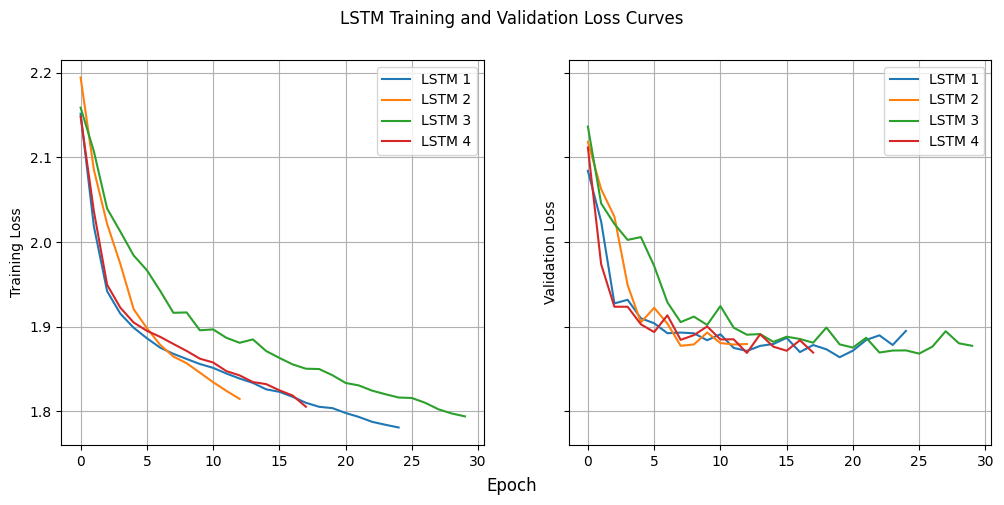

In [18]:
# lstm training/validation loss curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

ax1.plot(lstm_1_history.history['loss'], label='LSTM 1')
ax1.plot(lstm_2_history.history['loss'], label='LSTM 2')
ax1.plot(lstm_3_history.history['loss'], label='LSTM 3')
ax1.plot(lstm_4_history.history['loss'], label='LSTM 4')
ax1.legend()
ax1.set_ylabel('Training Loss')
ax1.grid()

ax2.plot(lstm_1_history.history['val_loss'], label='LSTM 1')
ax2.plot(lstm_2_history.history['val_loss'], label='LSTM 2')
ax2.plot(lstm_3_history.history['val_loss'], label='LSTM 3')
ax2.plot(lstm_4_history.history['val_loss'], label='LSTM 4')
ax2.legend()
ax2.set_ylabel('Validation Loss')
ax2.grid()

fig.suptitle('LSTM Training and Validation Loss Curves')
fig.supxlabel('Epoch')
plt.show()

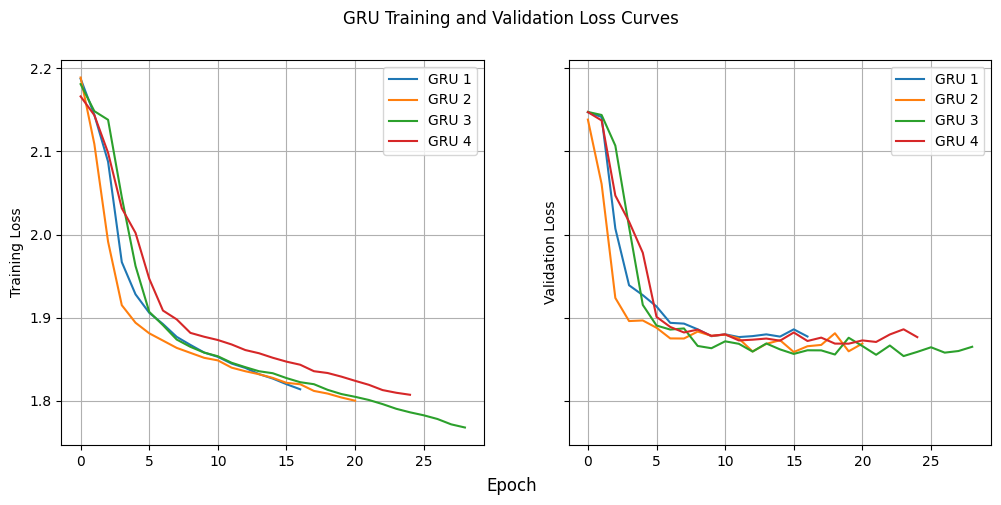

In [19]:
# gru training/validation loss curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

ax1.plot(gru_1_history.history['loss'], label='GRU 1')
ax1.plot(gru_2_history.history['loss'], label='GRU 2')
ax1.plot(gru_3_history.history['loss'], label='GRU 3')
ax1.plot(gru_4_history.history['loss'], label='GRU 4')
ax1.legend()
ax1.set_ylabel('Training Loss')
ax1.grid()

ax2.plot(gru_1_history.history['val_loss'], label='GRU 1')
ax2.plot(gru_2_history.history['val_loss'], label='GRU 2')
ax2.plot(gru_3_history.history['val_loss'], label='GRU 3')
ax2.plot(gru_4_history.history['val_loss'], label='GRU 4')
ax2.legend()
ax2.set_ylabel('Validation Loss')
ax2.grid()

fig.suptitle('GRU Training and Validation Loss Curves')
fig.supxlabel('Epoch')
plt.show()

## Takeaways

- Both the LSTM and GRU models outperform the vanilla RNN model, while also giving minimal improvements over the baseline MLP models
- The best models have validation accuracy around **37%** and loss around **1.86**
- There is some overfitting to the training data in all cases which was reduced with dropout
- Architectures with fewer gated layers learned more quickly but ultimately resulted in similar performance